In [44]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

**Dataset**
- 1번함체: CG_1(이격), CG_2(침하) // TT_1 (상부경사), TT_2 (하부경사)
- 2번함체: CG_3(이격), CG_4(침하) // TT_3 (상부경사), TT_4 (하부경사)
- 온도: TC_1_Avg(concrete temp), TC_2_Avg(air temp)
- Label: 0(baseline), 1(outliers) // 2023.01.01: Initial point for abnomaly

In [64]:
df = pd.read_csv('J_Dataset_1101_0630.csv')
df

,Time,Label,CG_1,CG_2,CG_3,CG_4,TT_1,TT_2,TT_3,TT_4,TC_1_Avg,TC_2_Avg,Waterlevel
0,2022-11-01 00:00:00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.06,14.44,563.0
1,2022-11-01 00:10:00,0,0.002000,-0.003000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,13.07,14.56,543.0
2,2022-11-01 00:20:00,0,0.005000,-0.005000,0.004000,0.001000,-0.001000,0.000000,-0.001000,0.000000,13.10,14.38,523.0
3,2022-11-01 00:30:00,0,0.008000,-0.007000,0.005000,0.001000,-0.001000,0.000000,-0.001000,-0.001000,13.13,14.34,504.0
4,2022-11-01 00:40:00,0,0.011000,-0.009000,0.007000,0.001000,-0.001000,0.000000,-0.001000,-0.001000,13.16,14.45,484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34032,2023-06-30 23:10:00,1,-1.363999,-0.347368,-0.532117,0.324241,0.048206,0.297531,0.035239,0.095782,25.93,23.42,458.0
34033,2023-06-30 23:20:00,1,-1.355999,-0.348368,-0.523117,0.323241,0.047206,0.297531,0.035239,0.095782,25.82,23.29,480.0
34034,2023-06-30 23:29:59,1,-1.347999,-0.349368,-0.514117,0.322241,0.047206,0.297531,0.034239,0.095782,25.72,23.24,503.0
34035,2023-06-30 23:40:00,1,-1.339999,-0.350368,-0.505117,0.321241,0.047206,0.296531,0.034239,0.095782,25.65,23.15,527.0


#### **Convert time stamp**

In [69]:
t = pd.to_datetime(df.Time)
normal_ind = df.Label == 0
abnormal_ind = df.Label == 1

print(sum(normal_ind), sum(abnormal_ind))

8784 25253


#### **Check Labels**

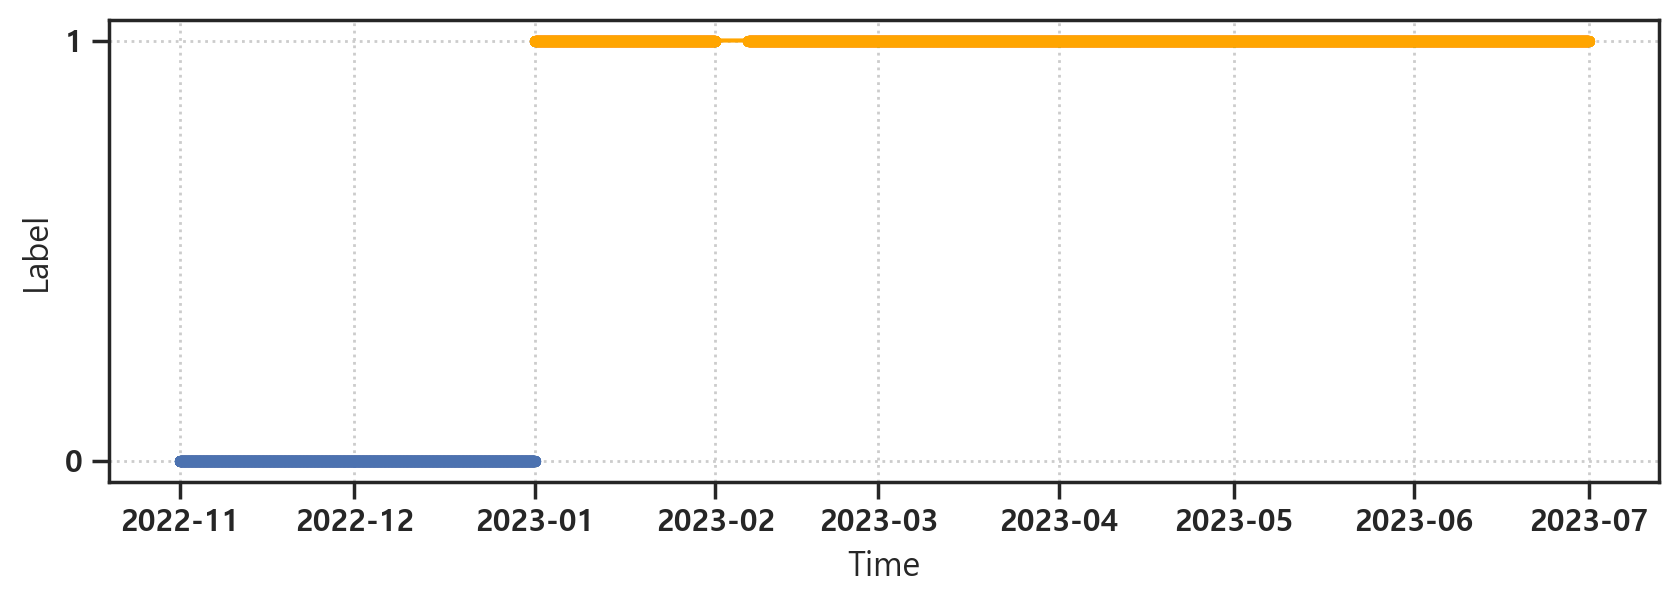

In [67]:
plt.figure(figsize = (10, 3))
plt.plot(pd.to_datetime(df.Time)[normal_ind], df.Label[normal_ind], 'b.')
plt.plot(pd.to_datetime(df.Time)[abnormal_ind], df.Label[abnormal_ind], color = 'orange', marker= '.')
plt.xlabel('Time')
plt.ylabel('Label')
plt.gca().set_yticks([0, 1])
plt.grid(linestyle = ':')
plt.show()

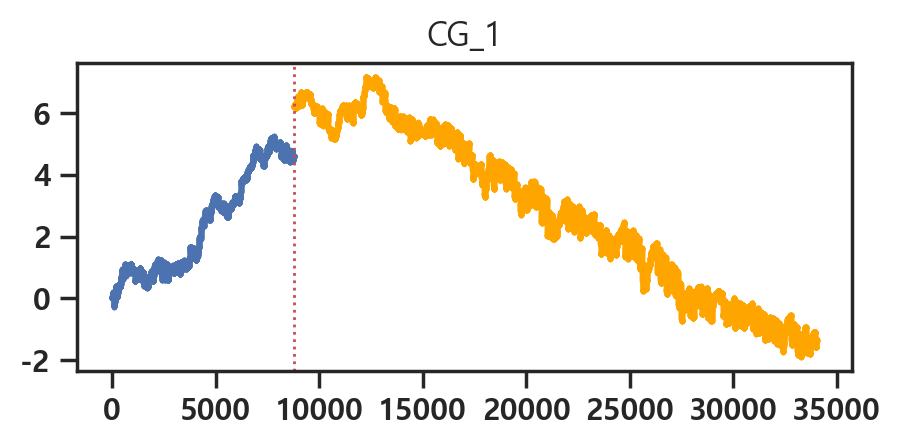

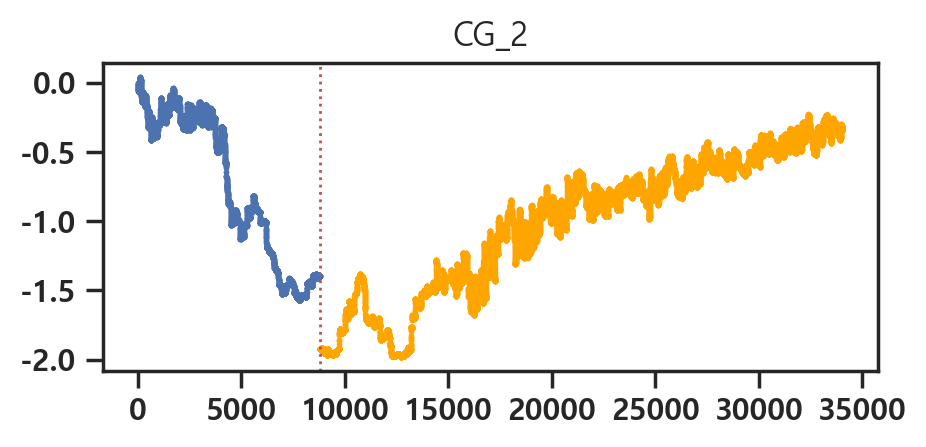

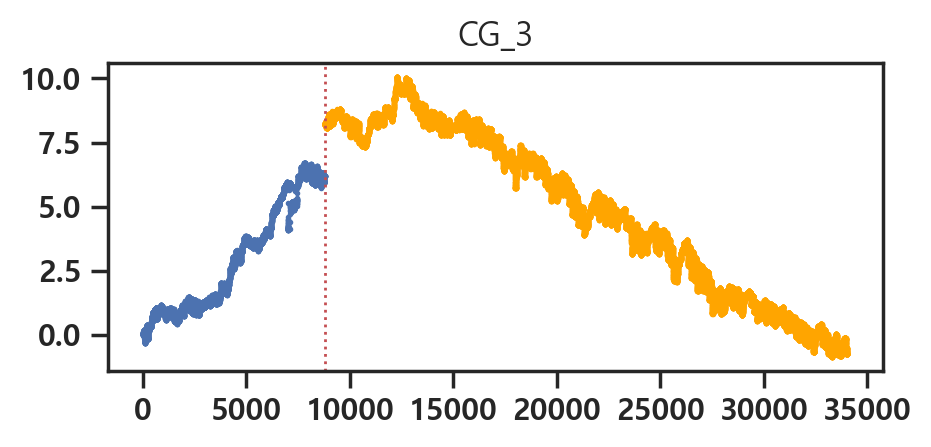

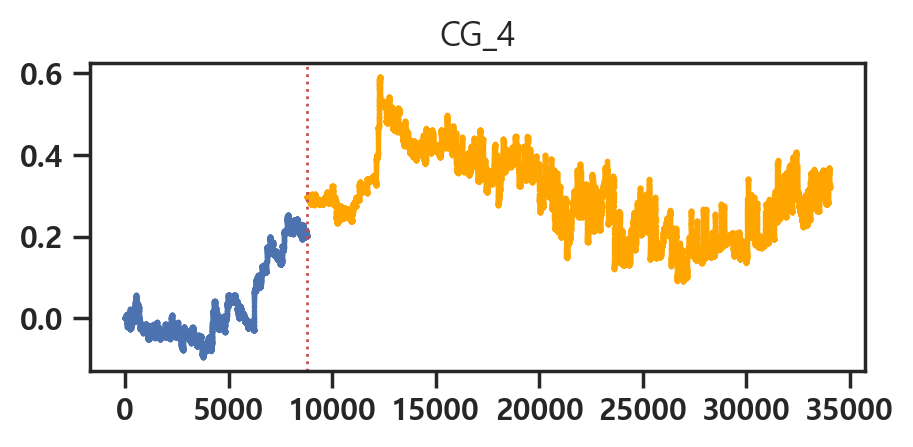

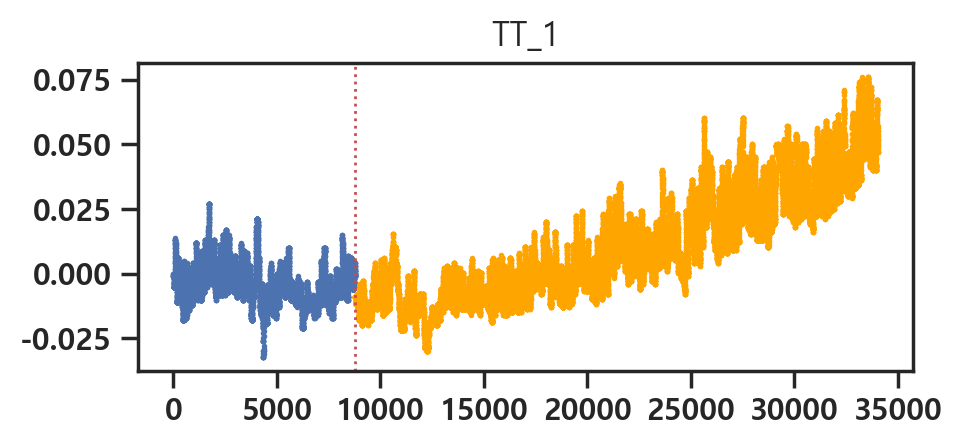

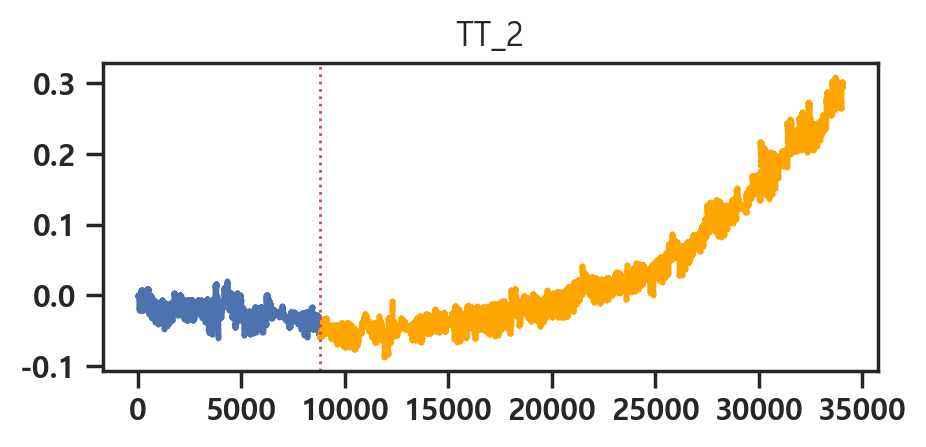

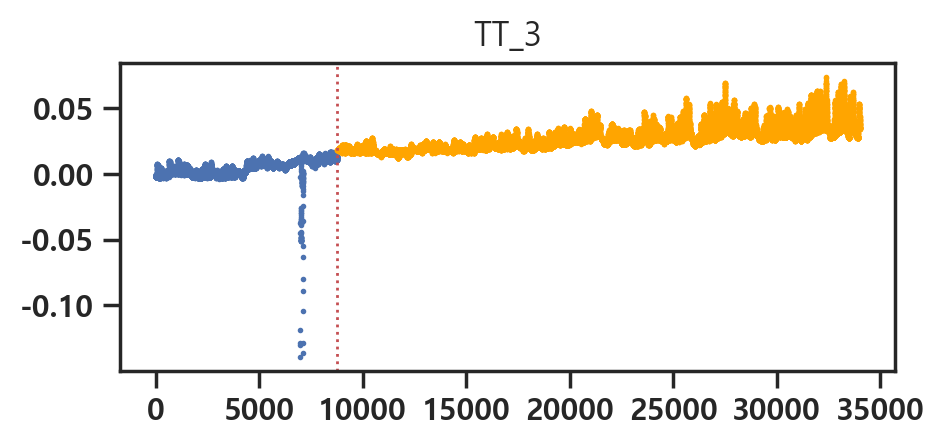

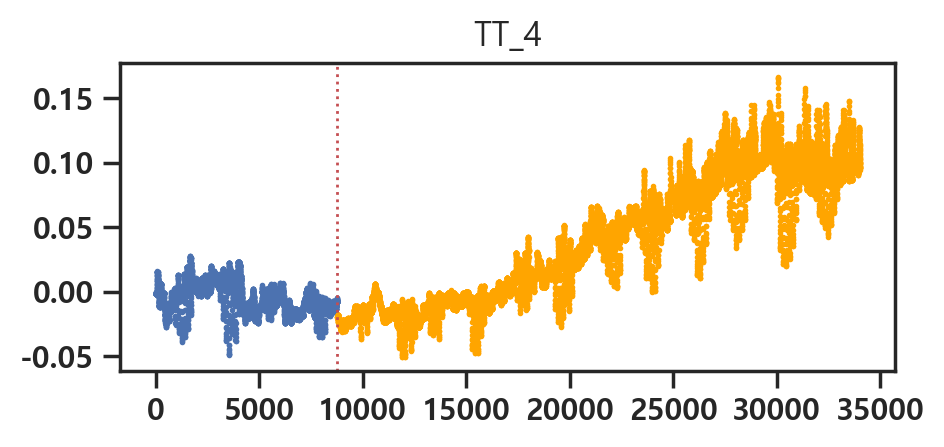

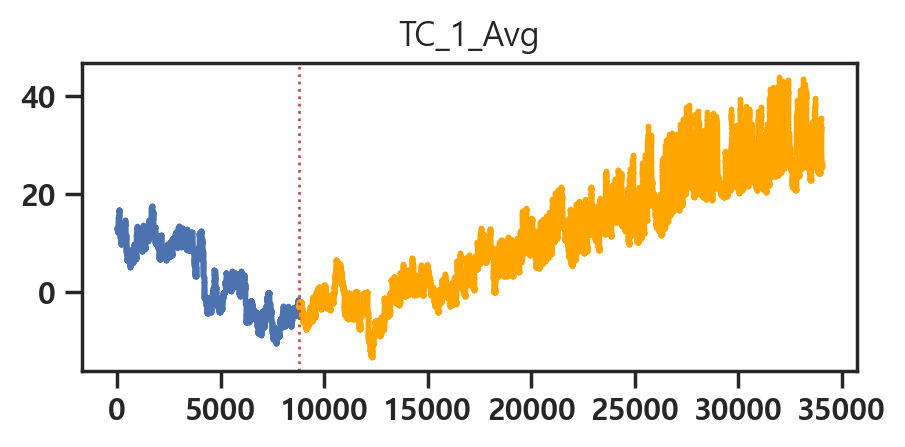

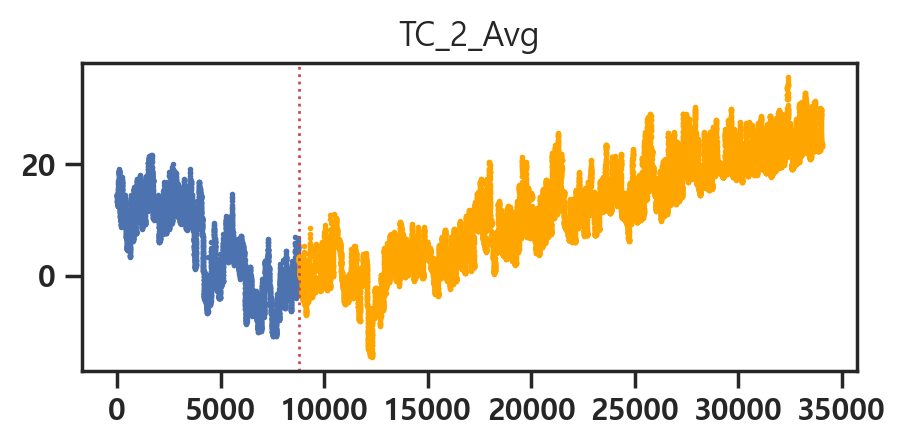

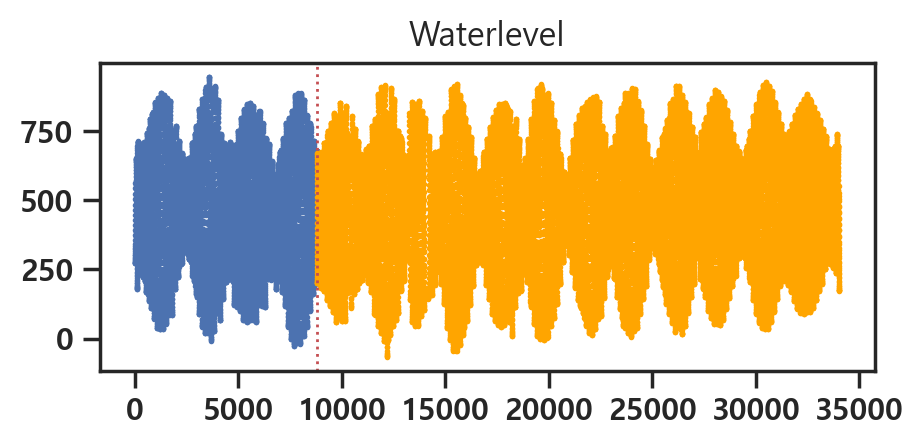

In [63]:
df_ = df[['CG_1', 'CG_2', 'CG_3', 'CG_4', 'TT_1', 'TT_2', 'TT_3', 'TT_4', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']]

for col in df_.columns:
    plt.plot(df_[col][normal_ind], '.', color = 'b', markersize = 2)
    plt.plot(df_[col][abnormal_ind], '.', color = 'orange', markersize = 2)
    plt.axvline(np.argmax(np.where(df.Label == 0)), color = 'r', linewidth = 1, linestyle = ':')
    plt.title(col)
    plt.show()

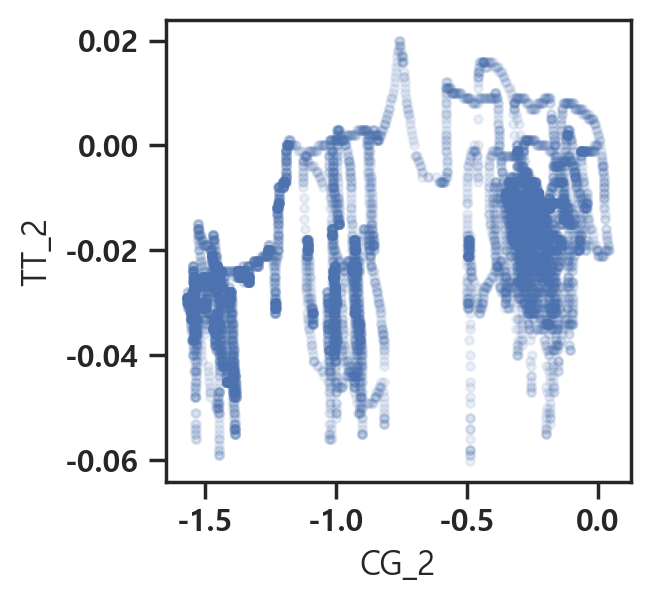

In [79]:
col_1, col_2 = 'CG_1', 'TT_1'
col_1, col_2 = 'CG_2', 'TT_2'
# col_1, col_2 = 'CG_3', 'TT_3'
# col_1, col_2 = 'CG_4', 'TT_4'

plt.figure(figsize = (3, 3))
plt.plot(df[col_1][normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.1)
plt.xlabel(col_1)
plt.ylabel(col_2)
plt.show()

df.columns

In [70]:
def plot_scatter_n_lineplots(cols, t, hue_types = ['normal', 'abnormal']):
    col_1, col_2 = cols
    
    normal_ind = df.Label == 0
    abnormal_ind = df.Label == 1

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    plt.xticks(rotation=45)
    fig3, ax3 = plt.subplots()
    plt.xticks(rotation=45)

    for hue_type in hue_types:
        if hue_type == 'normal':
            ax1.plot(df[col_1][normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.1)
            ax2.plot(t[normal_ind], df[col_1][normal_ind], 'b.', alpha = 0.3)
            ax3.plot(t[normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.3)
        elif hue_type == 'abnormal':
            ax1.plot(df[col_1][abnormal_ind], df[col_2][abnormal_ind], 'r.', alpha = 0.1)
            ax2.plot(t[abnormal_ind], df[col_1][abnormal_ind], 'r.', alpha = 0.3)
            ax3.plot(t[abnormal_ind], df[col_2][abnormal_ind], 'r.', alpha = 0.3)

    ax1.set_xlabel(col_1)
    ax1.set_ylabel(col_2)
    fig1.show()

    ax2.set_xlabel(col_1)
    fig2.show()
    
    ax3.set_xlabel(col_2)
    fig3.show()

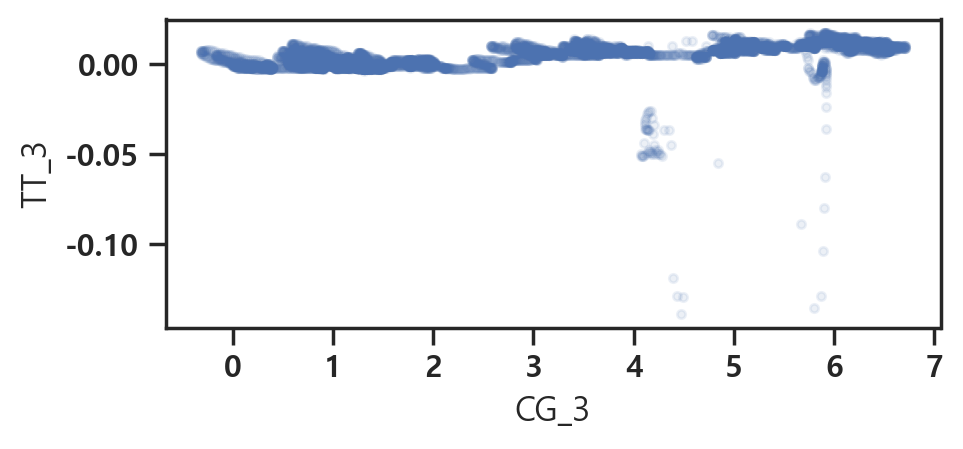

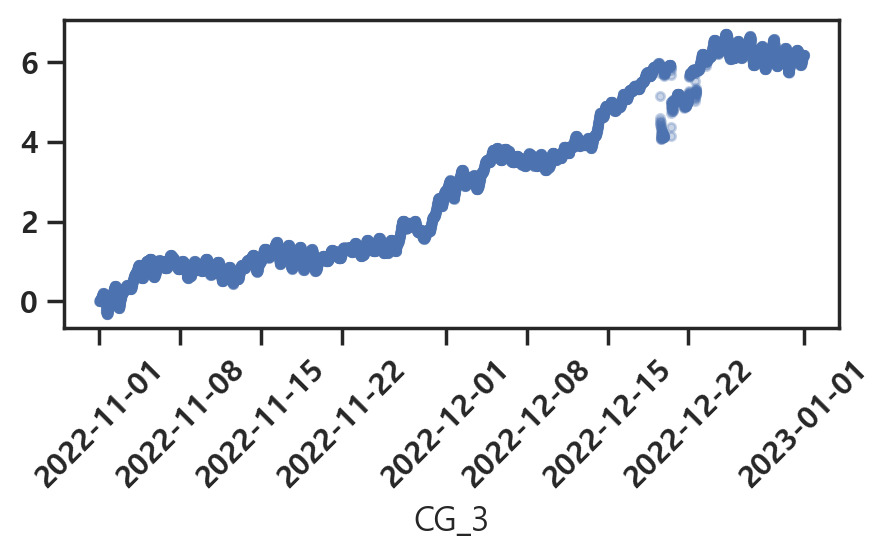

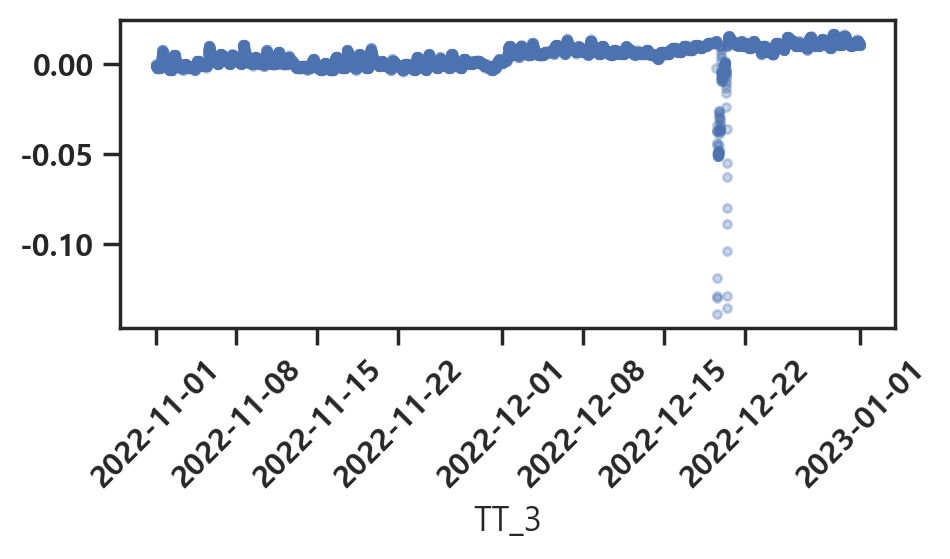

In [71]:
cols = 'CG_3', 'TT_3'
# plot_scatter_n_lineplots(cols, t, hue_types = ['normal', 'abnormal'])
plot_scatter_n_lineplots(cols, t, hue_types = ['normal'])
# plot_scatter_n_lineplots(cols, t, hue_types = ['abnormal'])

#### **Pairplots**

In [ ]:
# g = sns.pairplot(df[df.Label == 0], hue="Label", kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
# g = sns.pairplot(df[df.Label == 1], hue="Label", kind='reg', plot_kws={'line_kws':{'color':'black'}, 'scatter_kws': {'alpha': 0.1, 'color': 'orange'}})
# g = sns.pairplot(df[df.columns], hue="Label", kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

In [ ]:
df.columns

In [ ]:
col_interest = ['Label', 'CG_1', 'CG_2', 'TT_1', 'TT_2']
# col_interest = ['Label', 'CG_1', 'CG_2']

g = sns.pairplot(df[col_interest], hue="Label", kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

In [ ]:
col_interest = ['Label', 'CG_3', 'CG_4', 'TT_3', 'TT_4']

g = sns.pairplot(df[col_interest], hue="Label", kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})